### SetUp

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import string
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding
keras = tf.keras

2024-03-19 18:58:54.441206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Get the dataset

In [3]:
data_path = '/home/login/Documents/songdata.csv'
song_dataset = pd.read_csv(data_path, dtype = str)[:10]
song_dataset.sample()

,artist,song,link,text
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."


### First 10 songs

#### Preprocessing

In [12]:
print(string.punctuation)
x = song_dataset['text'].str
print(x)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [13]:
def tokenize_corpus(corpus, num_words = -1):
    if num_words > -1:
        tokenizer = Tokenizer(num_words = num_words)
    else:
        tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

def create_lyrics_corpus(dataset, field):
    dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
    dataset[field] = dataset[field].str.lower()
    # make a long string to split by line
    lyrics = dataset[field].str.cat()
#     print(lyrics)
    corpus = lyrics.split("\n")
#     print(corpus)
    # remove any trailing white spaces
    for _ in range(len(corpus)):
        corpus[_] = corpus[_].rstrip()
    # remove empty lines
    corpus = [_ for _ in corpus if _ != ""]
    return corpus
print(create_lyrics_corpus(song_dataset[:2], 'text'))

["look at her face, it's a wonderful face", 'and it means something special to me', 'look at the way that she smiles when she sees me', 'how lucky can one fellow be?', "she's just my kind of girl, she makes me feel fine", 'who could ever believe that she could be mine?', "she's just my kind of girl, without her i'm blue", 'and if she ever leaves me what could i do, what could i do?', 'and when we go for a walk in the park', 'and she holds me and squeezes my hand', "we'll go on walking for hours and talking", 'about all the things that we plan', "she's just my kind of girl, she makes me feel fine", 'who could ever believe that she could be mine?', "she's just my kind of girl, without her i'm blue", 'and if she ever leaves me what could i do, what could i do?', 'take it easy with me, please', 'touch me gently like a summer evening breeze', 'take your time, make it slow', 'andante, andante', 'just let the feeling grow', 'make your fingers soft and light', 'let your body be the velvet of t

/tmp/ipykernel_4542/487909910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
/tmp/ipykernel_4542/487909910.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = dataset[field].str.lower()


In [14]:
corpus = create_lyrics_corpus(song_dataset, 'text')
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1
print(tokenizer.word_index)
print(total_words)

{'you': 1, 'a': 2, 'i': 3, 'and': 4, 'me': 5, 'the': 6, 'is': 7, 'my': 8, 'to': 9, 'be': 10, 'ma': 11, 'it': 12, 'of': 13, "i'm": 14, 'your': 15, 'love': 16, 'so': 17, 'as': 18, 'boomerang': 19, 'that': 20, 'in': 21, 'andante': 22, 'boom': 23, 'make': 24, 'dumb': 25, 'on': 26, 'oh': 27, 'dum': 28, 'for': 29, 'but': 30, 'new': 31, 'bang': 32, "it's": 33, 'like': 34, 'know': 35, 'now': 36, 'how': 37, 'could': 38, "you're": 39, 'sing': 40, 'never': 41, 'no': 42, 'hum': 43, 'chiquitita': 44, 'can': 45, 'we': 46, 'song': 47, 'had': 48, 'good': 49, "you'll": 50, 'she': 51, 'just': 52, 'girl': 53, 'again': 54, 'will': 55, 'take': 56, 'please': 57, 'let': 58, 'am': 59, 'eyes': 60, 'was': 61, 'always': 62, 'cassandra': 63, 'blue': 64, 'time': 65, "don't": 66, 'were': 67, 'return': 68, 'once': 69, 'then': 70, 'sorry': 71, "cryin'": 72, 'over': 73, 'feel': 74, 'ever': 75, 'believe': 76, 'what': 77, 'do': 78, 'go': 79, 'all': 80, 'out': 81, 'think': 82, 'every': 83, 'leave': 84, 'look': 85, 'at': 

### Create sequences and labels

In [31]:
print(tokenizer.texts_to_sequences([corpus[0]]))
tok_list = tokenizer.texts_to_sequences([corpus[0]])[0]
print(tok_list)
for i in range(len(tok_list)):
    n_gram_seq = tok_list[:i+1]
    print(n_gram_seq)

[[85, 86, 146, 197, 33, 2, 285, 197]]
[85, 86, 146, 197, 33, 2, 285, 197]
[85]
[85, 86]
[85, 86, 146]
[85, 86, 146, 197]
[85, 86, 146, 197, 33]
[85, 86, 146, 197, 33, 2]
[85, 86, 146, 197, 33, 2, 285]
[85, 86, 146, 197, 33, 2, 285, 197]


In [37]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)
        
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen = max_sequence_len, padding = 'pre'))

input_sequences, labels = sequences[:,:-1], sequences[:,-1]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes = total_words)
    
print(tokenizer.word_index['know'])   
print(tokenizer.word_index['feeling'])

print(input_sequences[5])
print(input_sequences[6])

print(one_hot_labels[5])
print(one_hot_labels[6])

35
101
[  0   0   0   0   0   0   0   0   0   0   0   0   0  85  86 146 197  33
   2]
[  0   0   0   0   0   0   0   0   0   0   0   0  85  86 146 197  33   2
 285]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

### Train a Text Generation Model

In [63]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length = max_sequence_len - 1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history = model.fit(input_sequences, one_hot_labels, epochs = 200, verbose = 1)

Epoch 1/200
65/65 [==============================] - 6s 14ms/step - loss: 5.9938 - accuracy: 0.0318
Epoch 2/200
65/65 [==============================] - 1s 14ms/step - loss: 5.4170 - accuracy: 0.0414
Epoch 3/200
65/65 [==============================] - 1s 14ms/step - loss: 5.3438 - accuracy: 0.0448
Epoch 4/200
65/65 [==============================] - 1s 14ms/step - loss: 5.2774 - accuracy: 0.0395
Epoch 5/200
65/65 [==============================] - 1s 14ms/step - loss: 5.1909 - accuracy: 0.0424
Epoch 6/200
65/65 [==============================] - 1s 14ms/step - loss: 5.1060 - accuracy: 0.0525
Epoch 7/200
65/65 [==============================] - 1s 15ms/step - loss: 5.0321 - accuracy: 0.0544
Epoch 8/200
65/65 [==============================] - 1s 14ms/step - loss: 4.9511 - accuracy: 0.0660
Epoch 9/200
65/65 [==============================] - 1s 14ms/step - loss: 4.8810 - accuracy: 0.0717
Epoch 10/200
65/65 [==============================] - 1s 14ms/step - loss: 4.7828 - accuracy: 0.0871

65/65 [==============================] - 1s 16ms/step - loss: 1.2675 - accuracy: 0.7285
Epoch 83/200
65/65 [==============================] - 1s 16ms/step - loss: 1.2426 - accuracy: 0.7299
Epoch 84/200
65/65 [==============================] - 1s 16ms/step - loss: 1.2304 - accuracy: 0.7323
Epoch 85/200
65/65 [==============================] - 1s 16ms/step - loss: 1.2234 - accuracy: 0.7280
Epoch 86/200
65/65 [==============================] - 1s 16ms/step - loss: 1.2090 - accuracy: 0.7410
Epoch 87/200
65/65 [==============================] - 1s 16ms/step - loss: 1.1826 - accuracy: 0.7506
Epoch 88/200
65/65 [==============================] - 1s 16ms/step - loss: 1.1697 - accuracy: 0.7530
Epoch 89/200
65/65 [==============================] - 1s 16ms/step - loss: 1.1735 - accuracy: 0.7439
Epoch 90/200
65/65 [==============================] - 1s 16ms/step - loss: 1.1404 - accuracy: 0.7588
Epoch 91/200
65/65 [==============================] - 1s 16ms/step - loss: 1.1176 - accuracy: 0.7631
Epo

65/65 [==============================] - 1s 17ms/step - loss: 0.4924 - accuracy: 0.8835
Epoch 163/200
65/65 [==============================] - 1s 16ms/step - loss: 0.4855 - accuracy: 0.8840
Epoch 164/200
65/65 [==============================] - 1s 17ms/step - loss: 0.4841 - accuracy: 0.8820
Epoch 165/200
65/65 [==============================] - 1s 16ms/step - loss: 0.4839 - accuracy: 0.8854
Epoch 166/200
65/65 [==============================] - 1s 16ms/step - loss: 0.5053 - accuracy: 0.8753
Epoch 167/200
65/65 [==============================] - 1s 16ms/step - loss: 0.5091 - accuracy: 0.8753
Epoch 168/200
65/65 [==============================] - 1s 16ms/step - loss: 0.4899 - accuracy: 0.8767
Epoch 169/200
65/65 [==============================] - 1s 16ms/step - loss: 0.4992 - accuracy: 0.8777
Epoch 170/200
65/65 [==============================] - 1s 16ms/step - loss: 0.4903 - accuracy: 0.8830
Epoch 171/200
65/65 [==============================] - 1s 16ms/step - loss: 0.4779 - accuracy: 0

### Visualize the training graph

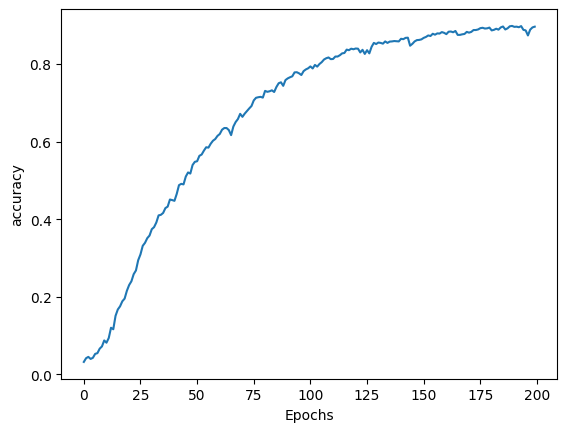

In [64]:
def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
    
plot_graphs(history, "accuracy")

### Generate new lyrics!

In [68]:
seed_text = "I am feeling chills"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = "pre")
#     print(token_list)
    predicted = model.predict(token_list, verbose = 0)
    predicted = np.argmax(predicted, axis = 1)
    output_word = ""
    
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    
print(seed_text)

I am feeling chills and i think he's gonna pain cool morning touch night velvet realized had look had stay stay together bone bone patch had me bone bone bone sun to stay stay together sorrow all ways a them such a them out that men good as new song take is was break here in of leaving face the last showing intention bone feeling love have de hum hum hum hum hum above you hum hum have good care making good care lost mistake good life new new new hum love he's feeling for new hum hum hum hum hum hum hum hum
